Imports

In [2]:
import pandas as pd
import json
import gzip 
import os
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns

Download pre-generated csv files

In [3]:
if not os.path.exists('reviews.crafts.csv'):
    !gdown --id 1qd9O-6QWfSUM2lfzvjDccM8U72ZQRzdS

Downloading...
From: https://drive.google.com/uc?id=1qd9O-6QWfSUM2lfzvjDccM8U72ZQRzdS
To: /content/reviews_crafts.csv
100% 93.7M/93.7M [00:01<00:00, 84.5MB/s]


Generate csv files from scratch

In [4]:
if not os.path.exists('reviews_crafts.csv'):
    !curl -O http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz
    def parse(path):
        g = gzip.open(path, 'rb')
        for l in g:
            yield json.loads(l)
    def getDF(path):
        i = 0
        df = {}
        for d in parse(path):
            df[i] = d
            i += 1
        return pd.DataFrame.from_dict(df, orient='index')

    getDF('Arts_Crafts_and_Sewing_5.json.gz')[['overall', 'asin', 'reviewText']].to_csv('reviews_crafts.csv')

Load in data

In [5]:
df = pd.read_csv('reviews_crafts.csv', index_col=0)
df.head()

,overall,asin,reviewText
0,4.0,0449819906,Contains some interesting stitches.
1,5.0,0449819906,I'm a fairly experienced knitter of the one-co...
2,4.0,0449819906,Great book but the index is terrible. Had to w...
3,5.0,0449819906,I purchased the Kindle edition which is incred...
4,5.0,0449819906,Very well laid out and very easy to read.\n\nT...


Get the top 5 most review products

In [6]:
most_reviewed_products = df['asin'].value_counts().iloc[:5]
most_reviewed_products

B000Y00DDK    3859
B00172XBQA    3857
B00281K7UW    1939
B0001DUD9O    1930
B000XZY8H8    1223
Name: asin, dtype: int64

Reduce dataframe to only include those 5 products

In [7]:
df = df[df['asin'].isin(most_reviewed_products.index)]
df.head()

,overall,asin,reviewText
3224,5.0,B0001DUD9O,Very very great yarn .. I will order more
3225,5.0,B0001DUD9O,Love this yarn. Love Red Heart.
3226,4.0,B0001DUD9O,"Loved it, fun colors. My husband calls it drag..."
3227,3.0,B0001DUD9O,matched
3228,5.0,B0001DUD9O,Love this yarn but have since found a lot chea...


Create a function to find and plot the most 20 frequent words in the review.

In [8]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

Next, we will remove punctuations and numbers from our text data if there is any

In [21]:
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Since some of the reviews contain numbers which is float values so we need to convert these float values to string values.

In [22]:

g=df['reviewText'].apply(lambda x: str(x))

In [23]:
g

3224              Very very great yarn    I will order more
3225                        Love this yarn  Love Red Heart 
3226      Loved it  fun colors  My husband calls it drag...
3227                                                matched
3228      Love this yarn but have since found a lot chea...
                                ...                        
427271    Good price for a large skein of yarn  Interest...
427272                             Wonderful   I need more 
427273    I couldn t find Red Heart Super Saver Yarn in ...
427274    Red heart super saver yarn is a great deal  My...
434572    Very bright and happy color   Love Red Heart  ...
Name: reviewText, Length: 12808, dtype: object

Plot the hist graph about the most frequent words in the review.

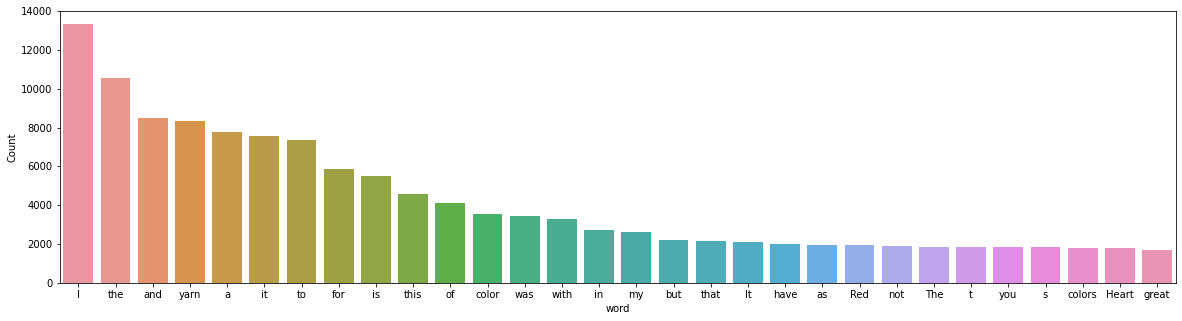

In [24]:
freq_words(g)

We can see that there are some common words such as "the", "to", "for", "this", "in", "a", "is", ... These words are not really important and relevant so we will remove them. First, we will try to remove stop words such as "a", "the", "is", "are" and short words (<3 letters) from the review.

In [27]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
g = g.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in g]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Plot the most frequent words in the review again to see if there are more significant words have come out.

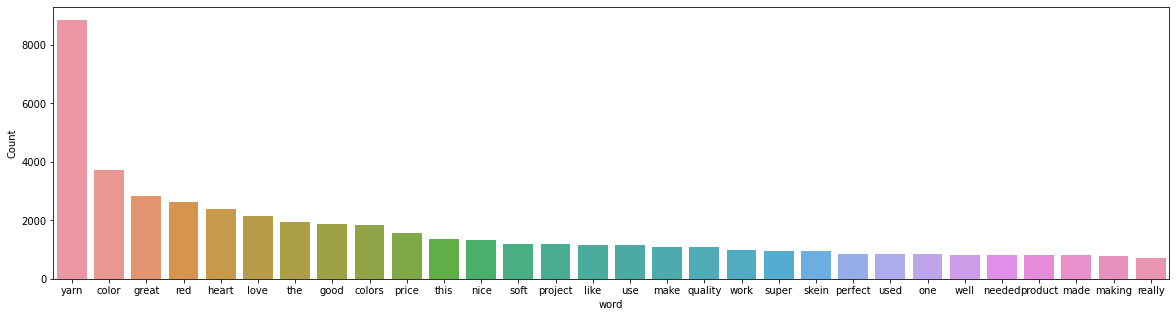

In [29]:
freq_words(reviews)

Looks like now we have more significant words such as "great", "good", "soft", "needed", "quality". 